In [11]:
import pandas as pd

# Charger le fichier CSV
df = pd.read_csv('C:/Users/my.kassem/Desktop/exploratory data analysis/df_filtre_status_type_description_resolution_copy.csv')

# Afficher les premières lignes du fichier
df

,Key,Type,Summary,Description,Status,Resolution,Resolution Date,Release Note,Priority,Created,...,Components,Fix Versions,Parent Issue,Watchers,Issue Links,Subtasks,Comments,Module-Feature,Module,Feature
0,DHRD-103268,Incident,CACEIS-PROD-IN-CP - Licence expirée depuis le ...,"Bonjour à tous,\r\nNous avons CACEIS qui nous ...",Resolved,Fixed,2025-01-23T10:45:39.000+0100,NaN,Blocker,2025-01-22T13:49:58.000+0100,...,Oth/other,NaN,NaN,1,NaN,NaN,[2025-01-22T13:58:13.000+0100] Hamid Ameziani:...,{'self': 'https://nx-jira8.my-nx.com/rest/api/...,00 - Installation & Tech Admin,Installation - Run Components
1,DHRD-103216,Story,TST - Manual override / Audit must be retested,"Due to improvements done with DHRD-100447, th...",Done,Fixed,2025-01-24T10:36:04.000+0100,NaN,Minor,2025-01-21T11:59:10.000+0100,...,NaN,NaN,NaN,0,outward: depends on DHRD-100447 [Done] - Story...,NaN,[2025-01-21T12:08:22.000+0100] Loic Brossard: ...,{'self': 'https://nx-jira8.my-nx.com/rest/api/...,05 - Web Client,Web Navigation & Searching
2,DHRD-103195,Problem,Can't Start Workers,||Version details||Environment infos||\r\n| * ...,Resolved,Fixed,2025-01-22T16:24:24.000+0100,NaN,Blocker,2025-01-20T17:23:57.000+0100,...,NaN,NaN,NaN,0,inward: blocks DHRD-100501 [Blocked] - [DH-7.1...,NaN,[2025-01-20T18:49:05.000+0100] Abir Arrari: Tr...,{'self': 'https://nx-jira8.my-nx.com/rest/api/...,02 - System Admin,"Scheduler, Tasks & Monitoring"
3,DHRD-103180,Bug,[AWS] S3 services failure with AWS_ROLE channel,||Version details||Environment infos||\r\n| * ...,Done,Fixed,2025-01-22T14:36:37.000+0100,NaN,Blocker,2025-01-20T16:06:24.000+0100,...,NaN,"DH-7.1.0.0, DH-7.2.0.0",NaN,0,inward: is created by DHRD-98328 [New] - [Clou...,NaN,[2025-01-20T16:23:44.000+0100] Mukesh Mishra: ...,{'self': 'https://nx-jira8.my-nx.com/rest/api/...,16 - Cloud & DevOps,AWS Deployment
4,DHRD-103113,Bug,[Regression] : NPE raised when using the Share...,||Version details||Environment infos||\r\n|VER...,Done,Fixed,2025-01-23T09:26:04.000+0100,NaN,Blocker,2025-01-17T08:22:51.000+0100,...,NaN,"DH-7.1.0.0, DH-7.2.0.0",NaN,0,outward: includes DHRD-103220 [To be tested] -...,NaN,[2025-01-20T16:01:08.000+0100] Chaid Fatoumbi:...,{'self': 'https://nx-jira8.my-nx.com/rest/api/...,15 - Tools,Evaluator
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15976,DHRD-7282,Bug,Import error : deadlock failure,"When importing a file, the error ""* Main error...",Closed,Fixed,2012-02-02T04:00:00.000+0100,"When importing data, the multisource module ha...",NaN,2012-02-02T04:00:00.000+0100,...,C/import,"DH-3.2-00b, DH-3.3-00",NaN,0,outward: includes DHRD-21348 [Test failed] - [...,NaN,NaN,{'self': 'https://nx-jira8.my-nx.com/rest/api/...,06 - Mapping & Connectivity,NaN
15977,DHRD-7281,Improvement,Evolutions mineures sur l'environnement des bu...,Bizness rule:\no chercher une autre bizule en ...,Closed,Fixed,2012-02-02T03:56:00.000+0100,Some bugs have been fixed and various improvem...,NaN,2012-02-02T03:56:00.000+0100,...,Cor/rule dict.,DH-3.3-00,NaN,0,outward: includes DHRD-21347 [Validated] - [DH...,NaN,NaN,{'self': 'https://nx-jira8.my-nx.com/rest/api/...,01 - Core Admin,NaN
15978,DHRD-7280,Bug,L'icone des mails interne en attente est HS...,L'icone de boîte mail situé en bas de l'écran ...,Closed,Fixed,2012-02-02T03:53:00.000+0100,NaN,NaN,2012-02-02T03:53:00.000+0100,...,Gui/components,DH-3.3-00,NaN,0,outward: includes DHRD-21346 [Validated] - [DH...,NaN,NaN,{'self': 'https://nx-jira8.my-nx.com/rest/api/...,04 - Rich Client,NaN
15979,DHRD-7279,Request,Ratings,Titres : \n - Les ratings côté titre sont faux...,Closed,Fixed,2012-02-01T04:13:00.000+0100,NaN,NaN,2012-02-01T04:13:00.000+0100,...,Oth/other,NaN,NaN,0,NaN,NaN,NaN,{'self': 'https://nx-jira8.my-nx.com/rest/api/...,09 - Data Enrichment,NaN


In [16]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import HDBSCAN
import umap.umap_ as umap  # Correction pour l'import UMAP
from keybert import KeyBERT
from collections import defaultdict

In [13]:
# 1. Modèle d'embedding léger

In [14]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2', device='cpu')


In [15]:
summaries = df['Summary'].tolist()  # Convertit la colonne en liste

In [17]:
embeddings = model.encode(summaries, show_progress_bar=True)


Batches: 100%|██████████| 500/500 [01:51<00:00,  4.47it/s]


In [19]:
# Étape 2: Réduction de dimension avec UMAP
umap_reducer = umap.UMAP(n_components=5, metric='cosine', random_state=42)
reduced_embeddings = umap_reducer.fit_transform(embeddings)

c:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [20]:
# Étape 3: Clustering avec HDBSCAN
clusterer = HDBSCAN(min_cluster_size=3, metric='euclidean')
clusters = clusterer.fit_predict(reduced_embeddings)

In [21]:
# Étape 4: Extraction de mots-clés par cluster avec KeyBERT
kw_model = KeyBERT()
cluster_keywords = defaultdict(list)

for cluster_id in set(clusters):
    if cluster_id != -1:  # -1 représente les points de bruit dans HDBSCAN
        cluster_texts = [text for text, c in zip(summaries, clusters) if c == cluster_id]
        keywords = kw_model.extract_keywords(" ".join(cluster_texts), keyphrase_ngram_range=(1, 2))
        cluster_keywords[cluster_id] = keywords


c:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\.venv\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\my.kassem\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [23]:
from pprint import pprint

print("📊 Topics et Mots-Clés par Cluster 📊")
print("="*50)
for cluster_id, keywords in cluster_keywords.items():
    print(f"\n🔵 Cluster {cluster_id} - Mots-Clés:")
    pprint([kw[0] for kw in keywords])  # Affiche seulement les termes, pas les scores
    
    # Affiche 3 exemples représentatifs
    cluster_samples = [text for text, c in zip(summaries, clusters) if c == cluster_id][:3]
    print("\nExemples de tickets:")
    for i, sample in enumerate(cluster_samples, 1):
        print(f"{i}. {sample}")
    print("-"*50)

📊 Topics et Mots-Clés par Cluster 📊

🔵 Cluster 0 - Mots-Clés:
['vulnerability okio',
 'vulnerability ocbc',
 'vulnerability 11396',
 'vulnerability 11495',
 'vulnerability 14534']

Exemples de tickets:
1. DataHub - Spring core Vulnerability 
2. [OCBC] Blackduck High Vulnerability - Netty 4.1.100.Final
3. High vulnerability in okio-2.10.0.jar
--------------------------------------------------

🔵 Cluster 1 - Mots-Clés:
['id cards', 'idcards implement', 'idcard idcards', 'idcards enable', 'idcard']

Exemples de tickets:
1. Ability to display ID Cards
2. Impossible de passer d'Id Card à grille
3. ID Card - make all cards clickable
--------------------------------------------------

🔵 Cluster 2 - Mots-Clés:
['exports csv', 'csv export', 'export csv', 'export csv1203', 'import csv']

Exemples de tickets:
1. [TBF] Import csv simulation
2. SKIP_FOOT_LINES doesn't skip the number of records expected for CSV parser
3. CITICS - Csv file import can not process value which has several quotation mar

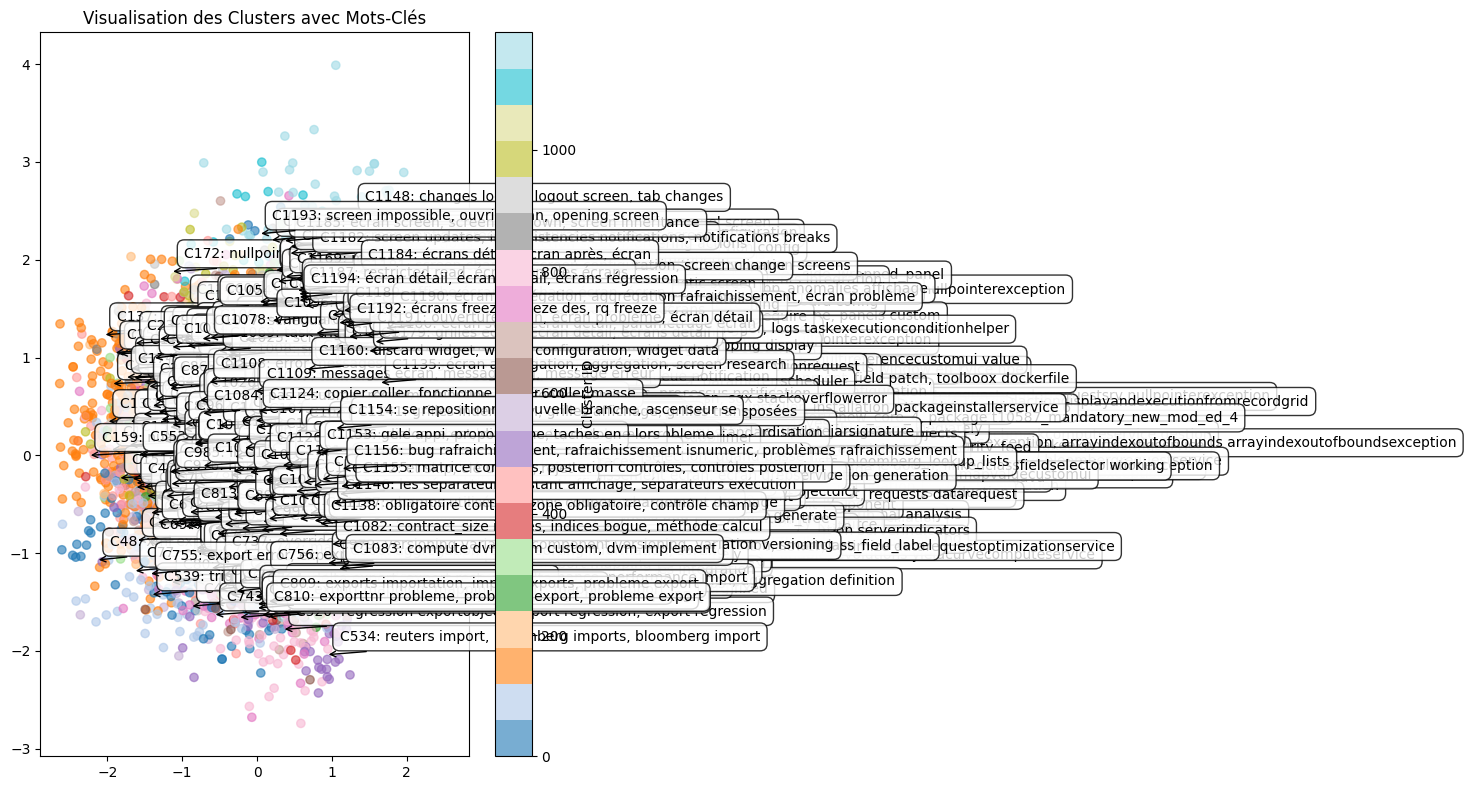

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Réduction dimensionnelle pour la visualisation
pca = PCA(n_components=2)
coords = pca.fit_transform(embeddings)

plt.figure(figsize=(12, 8))

# Couleurs par cluster
colors = [plt.cm.tab20(c) for c in clusters if c != -1]
filtered_coords = coords[[c != -1 for c in clusters]]

# Scatter plot
scatter = plt.scatter(
    filtered_coords[:, 0], 
    filtered_coords[:, 1], 
    c=[c for c in clusters if c != -1],
    cmap='tab20',
    alpha=0.6
)

# Annotations des mots-clés
for cluster_id in cluster_keywords.keys():
    # Position moyenne du cluster
    cluster_points = coords[clusters == cluster_id]
    mean_pos = cluster_points.mean(axis=0)
    
    # Top 3 mots-clés
    top_keywords = ", ".join([kw[0] for kw in cluster_keywords[cluster_id][:3]])
    
    plt.annotate(
        f"C{cluster_id}: {top_keywords}",
        xy=mean_pos,
        xytext=(10, 10),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
        arrowprops=dict(arrowstyle='->')
    )

plt.colorbar(scatter, label='Cluster ID')
plt.title("Visualisation des Clusters avec Mots-Clés")
plt.tight_layout()
plt.show()

In [26]:
unique_clusters = set(clusters)  # Ensemble des IDs de clusters
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)  # Exclut les outliers

print(f"🔷 Nombre total de clusters identifiés : {num_clusters}")
print(f"🔶 Nombre de tickets non-clusterisés (outliers) : {list(clusters).count(-1)}")
print(f"📊 Répartition par cluster :\n{pd.Series(clusters).value_counts().sort_index()}")

🔷 Nombre total de clusters identifiés : 1195
🔶 Nombre de tickets non-clusterisés (outliers) : 5232
📊 Répartition par cluster :
-1       5232
 0         16
 1         11
 2         64
 3          3
         ... 
 1190       8
 1191      13
 1192       3
 1193       5
 1194      13
Name: count, Length: 1196, dtype: int64


In [27]:
unique_clusters = set(clusters)  # Ensemble des IDs de clusters
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)  # Exclut les outliers

print(f"🔷 Nombre total de clusters identifiés : {num_clusters}")
print(f"🔶 Nombre de tickets non-clusterisés (outliers) : {list(clusters).count(-1)}")
print("\n📊 Détail des clusters avec leurs noms :")

# Création d'un DataFrame pour l'affichage structuré
cluster_info = []
for cluster_id in sorted(unique_clusters):
    if cluster_id == -1:
        continue  # On ignore les outliers pour cette partie
    
    # Récupération des mots-clés principaux
    top_keywords = [kw[0] for kw in cluster_keywords.get(cluster_id, [])[:3]]
    cluster_name = " / ".join(top_keywords)  # Combine les 3 premiers mots-clés
    
    cluster_info.append({
        "Cluster ID": cluster_id,
        "Nom du Cluster": cluster_name,
        "Nombre de tickets": list(clusters).count(cluster_id),
        "Mots-clés": ", ".join(top_keywords)
    })

# Affichage sous forme de tableau
import pandas as pd
df_clusters = pd.DataFrame(cluster_info)
print(df_clusters[["Cluster ID", "Nom du Cluster", "Nombre de tickets"]].to_string(index=False))

# Version alternative avec print standard
print("\n📌 Version détaillée :")
for info in cluster_info:
    print(f"\n● Cluster {info['Cluster ID']} - \"{info['Nom du Cluster']}\"")
    print(f"  Tickets: {info['Nombre de tickets']}")
    print(f"  Mots-clés complets: {info['Mots-clés']}")

🔷 Nombre total de clusters identifiés : 1195
🔶 Nombre de tickets non-clusterisés (outliers) : 5232

📊 Détail des clusters avec leurs noms :
 Cluster ID                                                                                                                                                     Nom du Cluster  Nombre de tickets
          0                                                                                                      vulnerability okio / vulnerability ocbc / vulnerability 11396                 16
          1                                                                                                                      id cards / idcards implement / idcard idcards                 11
          2                                                                                                                              exports csv / csv export / export csv                 64
          3                                                                         

In [28]:
import pandas as pd
from IPython.display import display, HTML

# Création d'un DataFrame complet
df_clusters = pd.DataFrame({
    'Cluster': clusters,
    'Summary': summaries
})

# Ajout des noms de clusters
cluster_names = {row['Cluster ID']: row['Nom du Cluster'] 
                for row in cluster_info}
df_clusters['Nom_Cluster'] = df_clusters['Cluster'].map(cluster_names)

In [ ]:
from ipywidgets import interact, IntSlider

def show_cluster(cluster_id=-2, page=1, page_size=10):
    if cluster_id == -2:  # Vue globale
        display(HTML("<h2>Vue Globale des Clusters</h2>"))
        display(df_clusters['Nom_Cluster'].value_counts().to_frame('Nombre de tickets'))
    else:
        cluster_data = df_clusters[df_clusters['Cluster'] == cluster_id]
        total = len(cluster_data)
        start = (page-1)*page_size
        end = min(start + page_size, total)
        
        display(HTML(f"""
        <h2>Cluster {cluster_id} - {cluster_names.get(cluster_id, 'Outlier')}</h2>
        <p>Affichage des tickets {start+1}-{end} sur {total}</p>
        """))
        display(cluster_data.iloc[start:end][['Summary']])

# Interface interactive
interact(
    show_cluster,
    cluster_id=[-2] + sorted(df_clusters['Cluster'].unique()),
    page=IntSlider(min=1, max=100, step=1, value=1),
    page_size=[10, 20, 50, 100]
)